# This notebook is for tests of the 1D $P_{F} (k)$ concerning resolution and noise

Please follow the **[this notebook](QA_plots.ipynb)** notebook for general remarks on how to set up the environment at NERSC, **maybe use [the developer edition of the notebook server](jupyter-dev.nersc.gov)** as this runs on a high-memory cori node (and should even allow generating batch jobs on arbitrary nodes from within the notebook) vs. some special thing in the standard version.

## imports

In [177]:
from pathlib import Path
import subprocess
import glob
import sys
import numpy as np
import scipy as sp
import scipy.stats as spstats
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits   #this is currently only used for slicing the catalogue, maybe get rid of the dependency by restructuring
import picca
from picca.Pk1D import Pk1D
from matplotlib import rc,rcParams

## set plotting style options

In [178]:
rcParams['text.usetex'] = False                      #setting this to true causes problems on NERSC because some files can't be created without sudo-rights
#rcParams['text.latex.unicode'] = True
rcParams['font.family'] = 'sans-serif'
#rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

%matplotlib inline

## set flags and variables

Stuff needed if only a subset of the full catalogue should be used (to speed things up for debugging)

In [179]:
usesubset=True     #should a subset of the full catalogue be used (note that everything takes hours if this is set to False)
rarange=2          #range in ra for subset
decrange=2         #range in dec for subset

Definition of variables needed to define the mocks

In [180]:
mock_base = '/project/projectdirs/desi/mocks/lya_forest/london/v4.0.8/'
quick_ver = 'quick-2.0'

## File/Directory names

Picca installation path and a string to activate the environment for subprocesses

In [181]:
piccadir=Path('/'+'/'.join(Path(picca.__file__).parts[1:-3])+'/')
activate_string='bash -c "source activate picca_plots;'

Catalogue file for the full catalogue

In [182]:
catfile=Path('{}/{}/zcat_desi_drq.fits'.format(mock_base,quick_ver))

Mock files

In [183]:
indir=Path('{}/{}/spectra-16/'.format(mock_base,quick_ver))

Output directories/files for the subset of mocks, the delta fields and Pk

In [184]:
outcatfile=Path.home()/'catalogues_small/'/('_'.join(catfile.parts[-4:])[:-5]+'_reduced_rarange{}_decrange{}.fits'.format(rarange,decrange))
outdir_delta=Path.home()/'res_ascii{}/'.format('_subset_rarange{}_decrange{}'.format(rarange,decrange) if usesubset else '')
outdir_Pk=Path.home()/'Pk_fits{}/'.format('_subset_rarange{}_decrange{}'.format(rarange,decrange) if usesubset else '')

Check that output dirs exist (else create)

In [185]:
if usesubset and not outcatfile.parent.exists():
    Path.mkdir(outcatfile.parent,parents=True)
if not outdir_Pk.exists():
    Path.mkdir(outdir_Pk,parents=True)
if not outdir_delta.exists():
    Path.mkdir(outdir_delta,parents=True)

## Create a subset of the mock catalogue

open the mock catalogue

In [186]:
cat=fits.open(catfile)
dec=cat[1].data['DEC']
ra=cat[1].data['RA']

define some range to use

In [187]:
select=(np.abs(dec-40)<decrange)&(np.abs(ra-180)<rarange)

slice the catalogue

In [188]:
if usesubset:
    cat[1].data=cat[1].data[select]

write to a file

In [189]:
if usesubset:
    try:
        cat.writeto(outcatfile)
    except OSError:
        print('File exists, using existing file')

File exists, using existing file


## use picca to compute the delta field

generate the call defined by the directories above

In [203]:
callstring_delta=('{call} --in-dir {indir} --drq {drq} --out-dir {outdir} --mode desi --delta-format Pk1D_ascii --rebin 1 --lambda-min 3650. --lambda-max 7200.0 '
                  '--lambda-rest-min 1050.0 --lambda-rest-max 1180 --nproc 4 --order 0 --use-constant-weight'.format(
                     call=piccadir/'bin/do_deltas.py', indir=indir.as_posix()+'/',drq=(outcatfile if usesubset else catfile).as_posix(),outdir=outdir_delta.as_posix()+'/'))

In [204]:
#this is for testing with non-ascii intermediate formats
#callstring_delta=('{call} --in-dir {indir} --drq {drq} --out-dir {outdir} --mode desi --delta-format Pk1D --rebin 1 --lambda-min 3650. --lambda-max 7200.0 '
#                  '--lambda-rest-min 1050.0 --lambda-rest-max 1180 --nproc 4 --order 0 --use-constant-weight'.format(
#                     call=piccadir/'bin/do_deltas.py', indir=indir.as_posix()+'/',drq=(outcatfile if usesubset else catfile).as_posix(),outdir=outdir_delta.as_posix()+'/'))

In [205]:
callstring_delta

'/global/u1/m/mwalther/igmhub/picca/bin/do_deltas.py --in-dir /project/projectdirs/desi/mocks/lya_forest/london/v4.0.8/quick-2.0/spectra-16/ --drq /global/homes/m/mwalther/catalogues_small/london_v4.0.8_quick-2.0_zcat_desi_drq_reduced_rarange2_decrange2.fits --out-dir /global/homes/m/mwalther/res_ascii_subset_rarange2_decrange2/ --mode desi --delta-format Pk1D_ascii --rebin 1 --lambda-min 3650. --lambda-max 7200.0 --lambda-rest-min 1050.0 --lambda-rest-max 1180 --nproc 4 --order 0 --use-constant-weight'

---

define an additional string to enable launching subprocesses in the right conda environment

In [206]:
call_delta_full='{} {}"'.format(activate_string,callstring_delta)

use subprocess to actually run the call **do not execute this line unless you're willing to wait for minutes (for subsets) to hours (for full sample)**

TODO: Instead of using subprocess directly maybe use %%sbatch to create a batch script submitted to the queue (this needs some package installations however)

In [207]:
pr_delta=subprocess.run(args=call_delta_full,shell=True,check=True,capture_output=True)

In [208]:
pr_delta.stdout

b' zqso_min = 2.093220338983051\n zqso_max = 5.857142857142857\nmode: desi\n\n start               : nb object in cat = 848\n and thid>0          : nb object in cat = 848\n and ra!=dec         : nb object in cat = 848\n and ra!=0.          : nb object in cat = 848\n and dec!=0.         : nb object in cat = 848\n and z>0.            : nb object in cat = 848\n and z>zmin          : nb object in cat = 544\n and z<zmax          : nb object in cat = 544\nBAL_FLAG_VI not found\n\n\nFound 544 qsos\n\rread 0 of 3. ndata: 0\n\rread 1 of 3. ndata: 75\n\rread 2 of 3. ndata: 166\nfound 544 quasars in input files\n\niteration:  0\ndone\nINFO: using constant weights, skipping eta, var_lss, fudge fits\niteration:  1\ndone\nINFO: using constant weights, skipping eta, var_lss, fudge fits\niteration:  2\ndone\nINFO: using constant weights, skipping eta, var_lss, fudge fits\niteration:  3\ndone\nINFO: using constant weights, skipping eta, var_lss, fudge fits\niteration:  4\ndone\n'

## Compute the power with picca

In [209]:
callstring_Pk=('{call} --in-dir {indir} --in-format ascii --out-dir {outdir} --lambda-obs-min 3750. --noise-estimate pipeline --no-apply-filling'.format(
                     call=piccadir/'bin/do_Pk1D.py', indir=outdir_delta.as_posix(),outdir=outdir_Pk.as_posix()))

In [211]:
#this is for testing of non-ascii intermediate formats
#callstring_Pk=('{call} --in-dir {indir} --in-format fits --out-dir {outdir} --lambda-obs-min 3750. --noise-estimate pipeline --no-apply-filling'.format(
#                     call=piccadir/'bin/do_Pk1D.py', indir=outdir_delta.as_posix(),outdir=outdir_Pk.as_posix()))

In [212]:
callstring_Pk

'/global/u1/m/mwalther/igmhub/picca/bin/do_Pk1D.py --in-dir /global/homes/m/mwalther/res_ascii_subset_rarange2_decrange2 --in-format ascii --out-dir /global/homes/m/mwalther/Pk_fits_subset_rarange2_decrange2 --lambda-obs-min 3750. --noise-estimate pipeline --no-apply-filling'

---

define an additional string to enable launching subprocesses in the right conda environment

In [213]:
call_Pk_full='{} {}"'.format(activate_string,callstring_Pk)

use subprocess to actually run the call **do not execute this line unless you're willing to wait for minutes (for subsets) to hours (for full sample)**

In [214]:
pr_Pk=subprocess.run(args=call_Pk_full,shell=True,check=True,capture_output=True)

In [215]:
pr_Pk.stdout

b'\rread 0 of 3 0\n ndata =   67\n\rread 1 of 3 67\n ndata =   147\n\rread 2 of 3 147\n ndata =   469\nall done \n'

## Then plot (this is just executing Christophe's routine atm, the next section has the plot created within this notebook)

In [216]:
callstring_plot='{call} --in-dir {indir} --out-fig {outfile}'.format(call=piccadir/'bin/do_plot_pk1d.py',indir=outdir_Pk, outfile=outdir_Pk/'plot_pk1d.pdf')

In [217]:
callstring_plot

'/global/u1/m/mwalther/igmhub/picca/bin/do_plot_pk1d.py --in-dir /global/homes/m/mwalther/Pk_fits_subset_rarange2_decrange2 --out-fig /global/homes/m/mwalther/Pk_fits_subset_rarange2_decrange2/plot_pk1d.pdf'

---

define an additional string to enable launching subprocesses in the right conda environment

In [218]:
call_plot_full='{} {}"'.format(activate_string,callstring_plot)

use subprocess to actually run the call **do not execute this line unless you're willing to wait for minutes (for subsets) to hours (for full sample)**

In [219]:
pr_plot=subprocess.run(args=call_plot_full,shell=True,check=True,capture_output=True)

In [220]:
pr_plot.stdout

b'\n ndata =   98\n\n ndata =   208\n\n ndata =   706\nFigure(1600x800)\nall done \n'

## Create the plot again from within this notebook

arguments for the plot

In [221]:
args={}
args['reso_max']=85.
args['SNR_min']=2.
args['z_min']=2.1
args['out_fig']=outdir_Pk/'plot_pk1d_notebook.pdf'

settings for the plot

In [222]:
figure_file = args['out_fig']

zbins = [ 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6]   #maybe this should come later and be np.linspace(2.2,4.6,nb_z_bin)
colors = ['m', 'r', 'b', 'k', 'chartreuse', 'gold', 'aqua', 'slateblue', 'orange', 'mediumblue', 'darkgrey', 'olive', 'firebrick']
s = 6
fontt = 16
fontlab = 10
fontl =12

set up the desired binning (as in the BOSS paper)

In [223]:
nb_z_bin=13 #shouldn't this just be len(zbins)
nb_k_bin=35
k_inf=0.000813
k_bin_dist=0.000542
k_sup=k_inf + nb_k_bin*k_bin_dist

generate arrays (maybe not all are needed in the end)

In [224]:
sumPk = sp.zeros([nb_z_bin,nb_k_bin],dtype=sp.float64)
sumPk2 = sp.zeros([nb_z_bin,nb_k_bin],dtype=sp.float64)
sum = sp.zeros([nb_z_bin,nb_k_bin],dtype=sp.float64)
ek = sp.zeros([nb_k_bin],dtype=sp.float64)
k=k_inf + (np.arange(nb_k_bin)+0.5)*k_bin_dist

#old version (checked that new gives the same answer)
#k = sp.zeros([nb_k_bin],dtype=sp.float64)
#for ik in range (nb_k_bin) :
#    k[ik] = k_inf + (ik+0.5)*0.000542

search for all P(k) files

In [225]:
fi = glob.glob("{}/*.fits.gz".format(outdir_Pk))

initialize the data arrays

In [226]:
data = {}
ndata = 0

loop over files

In [227]:
for i,f in enumerate(fi):
    if i%1==0:
        sys.stderr.write("\rread {} of {} {}".format(i,len(fi),ndata))

    # read fits files
    hdus = fitsio.FITS(f)
    pk1ds = [Pk1D.from_fitsio(h) for h in hdus[1:]]
    ndata+=len(pk1ds)
    print ("\n ndata =  ",ndata)

    # loop over pk1ds
    for pk in pk1ds:

        # Selection over the SNR and the resolution
        if (pk.mean_snr<=args['SNR_min'] or pk.mean_reso>=args['reso_max']) : continue

        if(pk.mean_z<=args['z_min']) : continue

        iz = int((pk.mean_z-args['z_min'])/0.2)
        if(iz>=nb_z_bin or iz<0) : continue
        for i in range (len(pk.k)) :
            ik = int((pk.k[i]-k_inf)/(k_sup-k_inf)*nb_k_bin);
            if(ik>= nb_k_bin or ik<0) : continue
            Delta2 = pk.Pk[i]*pk.k[i]/sp.pi
            sumPk[iz,ik] += Delta2
            sumPk2[iz,ik] += Delta2**2
            sum[iz,ik] += 1.0

read 2 of 3 208


 ndata =   98

 ndata =   208

 ndata =   706


Compute means and errors

In [228]:
meanPk = sp.where(sum!=0,sumPk/sum,0.0)
errorPk = sp.where(sum!=0,sp.sqrt(((sumPk2/sum)-meanPk**2)/sum),0.0)

/global/homes/m/mwalther/.conda/envs/picca_plots/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/m/mwalther/.conda/envs/picca_plots/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Do the actual plotting

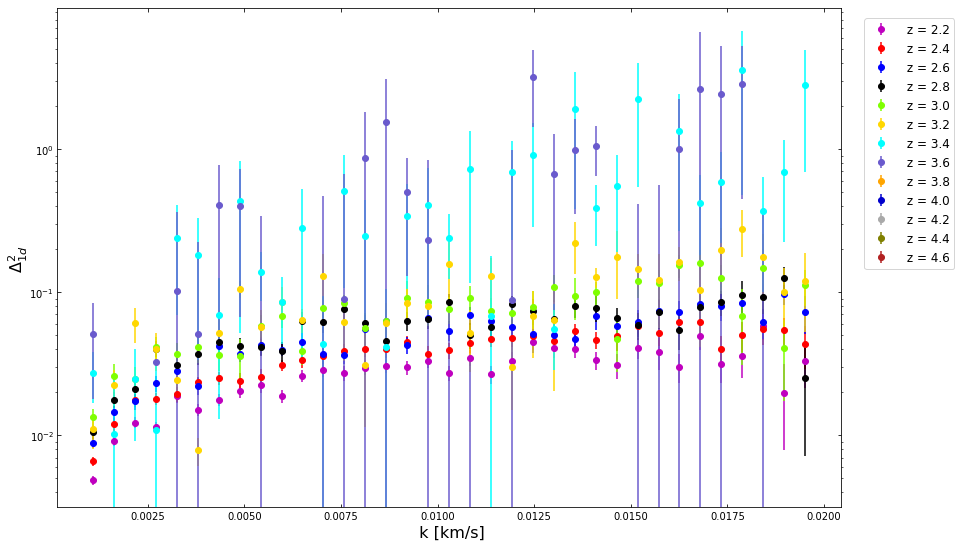

In [229]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)
plt.yscale('log')

for iz in range(nb_z_bin) :
    z = 2.2 + iz*0.2
    #ax.errorbar(k,meanPk[iz,:], yerr =errorPk[iz,:], fmt = 'o', color = colors[iz], markersize = s, label =r'\bf {:1.1f} $\displaystyle <$ z $\displaystyle <$ {:1.1f}'.format(z-0.1,z+0.1))
    ax.errorbar(k,meanPk[iz,:], yerr =errorPk[iz,:], fmt = 'o', color = colors[iz], markersize = s, label =r' z = {:1.1f}'.format(z))

#ax.set_xlabel(r'\bf $\displaystyle k [km.s^{-1}]$', fontsize = fontt)
ax.set_xlabel(r' k [km/s]', fontsize = fontt)
#ax.set_ylabel(r'\bf $\displaystyle \Delta^2_{\mathrm{1d}}(k) $', fontsize=fontt, labelpad=-1)
ax.set_ylabel(r'$\Delta^2_{1d}$ ', fontsize=fontt, labelpad=-1)
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_tick_params(direction='in')
ax.xaxis.set_tick_params(labelsize=fontlab)
ax.yaxis.set_tick_params(labelsize=fontlab)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.03, 0.98), borderaxespad=0.,fontsize = fontl)
fig.subplots_adjust(top=0.98,bottom=0.114,left=0.078,right=0.758,hspace=0.2,wspace=0.2)

fig.savefig(figure_file, transparent=False)